In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
set_seed(123)
epochs = 3
batch_size = 16
max_length = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'
labels_ids = {0: 0, 1: 1}
n_labels = len(labels_ids)

In [2]:
def get_data(path, augmented = False):
    if augmented:
        df = pd.read_csv(path)
        df.dropna(subset=['reviewContent', 'label'], inplace=True)
        return df
    df = pd.read_csv(path)
    df.dropna(subset=['reviewContent', 'label'], inplace=True)
    df1 = df[df.label == 1]
    df2 = df[df.label == 0].sample(n=df1.shape[0], random_state=1)
    new_df = pd.concat([df1, df2], ignore_index=True)

    data = new_df.sample(frac=1, random_state=2)
    return data

In [3]:
data = get_data('augmentedReviewsCSV.csv', augmented=True)

train_data = data.sample(frac=0.8, random_state=1)
val_data = data.drop(train_data.index)

with open('./GPT_2/data/train_data.csv', 'w') as f:
    train_data.to_csv(f, index=False)

with open('./GPT_2/data/val_data.csv', 'w') as f:
    val_data.to_csv(f, index=False)


In [4]:
class ReviewsDataset(Dataset):
  def __init__(self, path, use_tokenizer = None):
    data = pd.read_csv(path)
    self.texts = data['reviewContent'].tolist()
    self.labels = data['label'].tolist()
    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder
        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  global model

  predictions_labels = []
  true_labels = []

  total_loss = 0


  model.train()


  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()

    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    logits = logits.detach().cpu().numpy()

    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader)
  
  return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):
  global model

  predictions_labels = []
  true_labels = []
  total_loss = 0

  model.eval()

  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():        

        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss


In [5]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)


print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = model.config.eos_token_id

model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [6]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
train_dataset = ReviewsDataset(path='./GPT_2/data/train_data.csv', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')

valid_dataset =  ReviewsDataset(path='./GPT_2/data/val_data.csv', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


Dealing with Train...
Created `train_dataset` with 74794 examples!
Created `train_dataloader` with 4675 batches!

Dealing with Validation...
Created `valid_dataset` with 18699 examples!
Created `eval_dataloader` with 1169 batches!


In [7]:
labels_ids, n_labels

({0: 0, 1: 1}, 2)

/home/gaurav/Documents/ASU/SWM Project/env/lib/python3.8/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/3 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/4675 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1169 [00:00<?, ?it/s]

  train_loss: 0.29136 - val_loss: 0.24883 - train_acc: 0.87177 - valid_acc: 0.89203


Training on batches...


  0%|          | 0/4675 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1169 [00:00<?, ?it/s]

  train_loss: 0.21190 - val_loss: 0.20999 - train_acc: 0.91073 - valid_acc: 0.91262


Training on batches...


  0%|          | 0/4675 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1169 [00:00<?, ?it/s]

  train_loss: 0.18849 - val_loss: 0.20560 - train_acc: 0.91961 - valid_acc: 0.91513



/home/gaurav/Documents/ASU/SWM Project/env/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


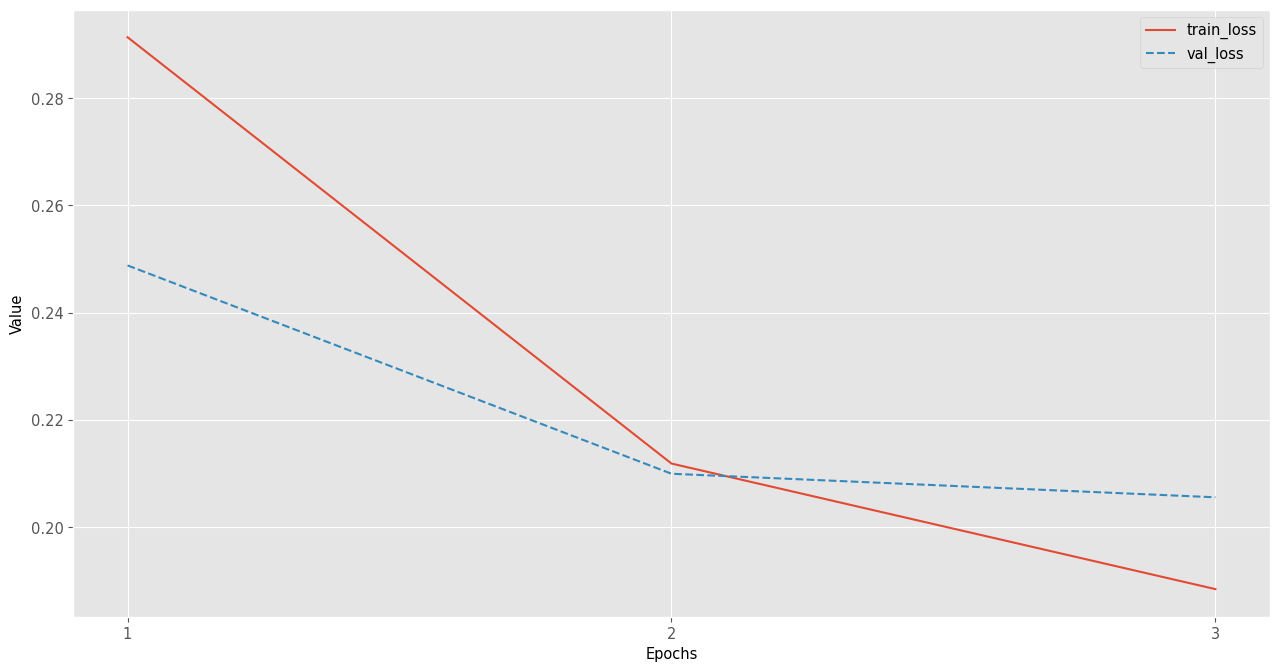

/home/gaurav/Documents/ASU/SWM Project/env/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


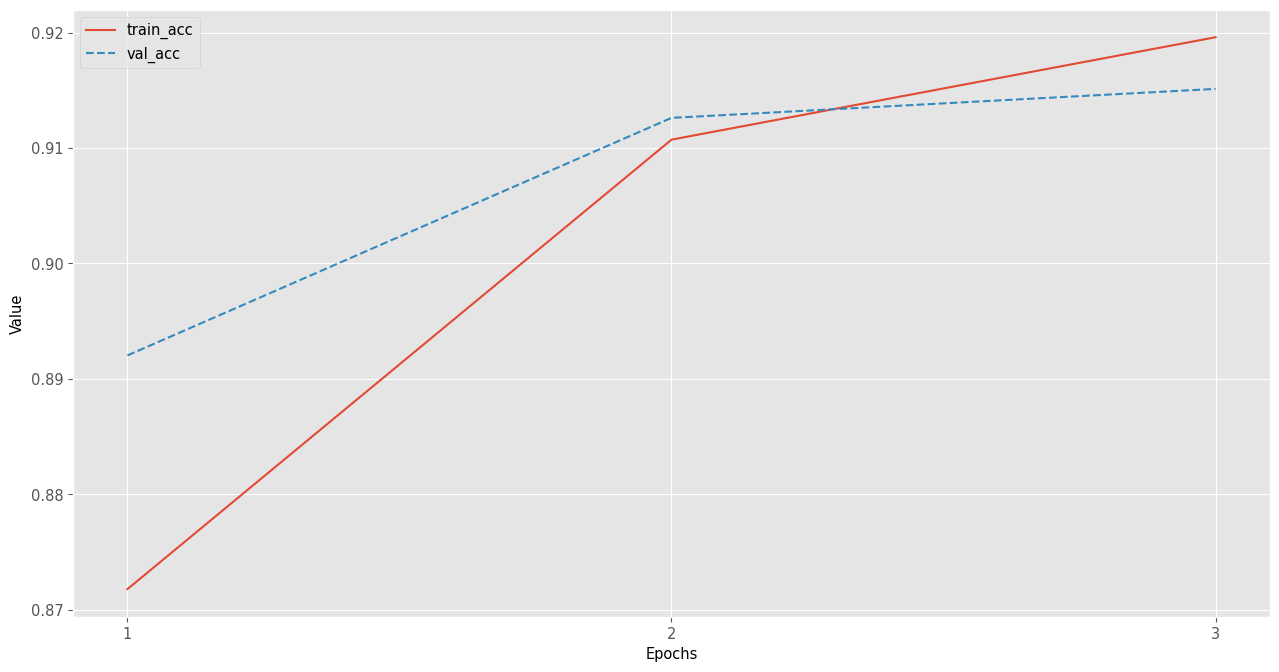

In [8]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

   
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)


plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


In [9]:
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

  0%|          | 0/1169 [00:00<?, ?it/s]

In [10]:
list(labels_ids.keys())

[0, 1]

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      9336
           1       0.94      0.89      0.91      9363

    accuracy                           0.92     18699
   macro avg       0.92      0.92      0.92     18699
weighted avg       0.92      0.92      0.92     18699

Normalized confusion matrix


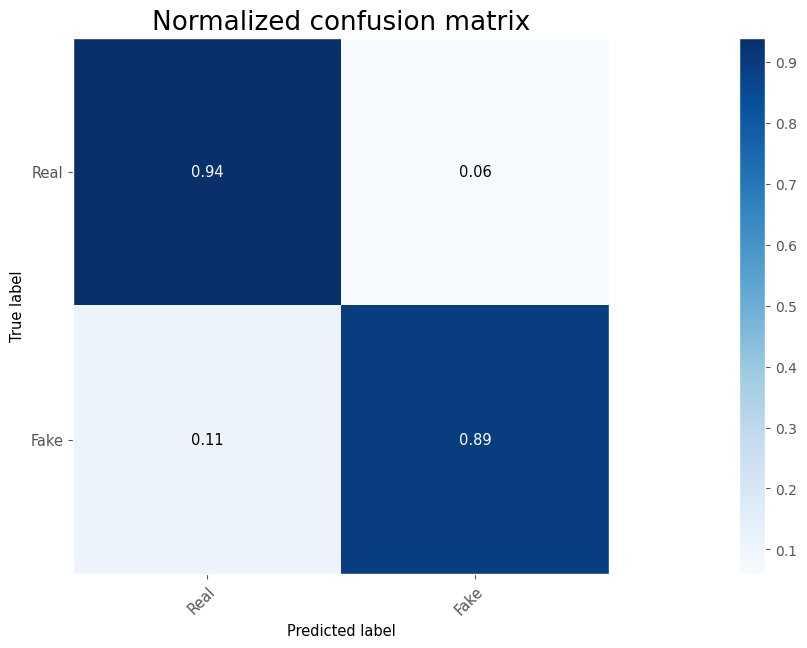

array([[0.94012425, 0.05987575],
       [0.10979387, 0.89020613]])

In [11]:
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()))
print(evaluation_report)
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=['Real', 'Fake'], normalize=True, 
                      magnify=0.1,
                      )
